In [1]:
import pandas as pd
import numpy as np
import sklearn

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
style.use('seaborn')

In [2]:
from sklearn.model_selection import KFold, GridSearchCV, cross_validate, ParameterGrid
from sklearn.feature_selection import RFECV
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.linear_model import RidgeCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor

In [49]:
def information(rtd):
    info = pd.DataFrame({'Column': rtd.columns})
    info['unique'] = [len(rtd[c].unique()) for c in rtd.columns]
    info['type'] = [rtd[c].dtype for c in rtd.columns]
    info['isNull'] = [sum(rtd[c].isnull()) for c in rtd.columns]
    info['mode example'] = [rtd[c].mode()[0] for c in rtd.columns]
    return info.set_index('Column')

In [50]:
loc_train = 'raw_data\\train.csv'
loc_test = 'raw_data\\test.csv'

target = 'SalePrice'
learning = 'Regression' # 'Regression' or 'Classification'
evaluation = 'neg_root_mean_squared_error'
Id = 'Id'

raw_train_data = pd.read_csv(loc_train)
y = raw_train_data[target]
raw_train_data = raw_train_data.drop(target, axis=1)
raw_test_data = pd.read_csv(loc_test)
raw_train_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [51]:
info = information(raw_train_data)
info

,unique,type,isNull,example
Column,,,,
Id,1460,int64,0,1
MSSubClass,15,int64,0,20
MSZoning,5,object,0,RL
LotFrontage,111,float64,259,60
LotArea,1073,int64,0,7200
...,...,...,...,...
MiscVal,21,int64,0,0
MoSold,12,int64,0,6
YrSold,5,int64,0,2009


In [7]:
info[info.isNull>0]

,unique,type,isNull
Column,,,
LotFrontage,111,float64,259
Alley,3,object,1369
MasVnrType,5,object,8
MasVnrArea,328,float64,8
BsmtQual,5,object,37
BsmtCond,5,object,37
BsmtExposure,5,object,38
BsmtFinType1,7,object,37
BsmtFinType2,7,object,38


In [8]:
for col in info[(info.type == 'object') & (info.isNull>0)].index:
    print (col, '\t', raw_train_data[col].unique())

Alley 	 [nan 'Grvl' 'Pave']
MasVnrType 	 ['BrkFace' 'None' 'Stone' 'BrkCmn' nan]
BsmtQual 	 ['Gd' 'TA' 'Ex' nan 'Fa']
BsmtCond 	 ['TA' 'Gd' nan 'Fa' 'Po']
BsmtExposure 	 ['No' 'Gd' 'Mn' 'Av' nan]
BsmtFinType1 	 ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
BsmtFinType2 	 ['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
Electrical 	 ['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]
FireplaceQu 	 [nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
GarageType 	 ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']
GarageFinish 	 ['RFn' 'Unf' 'Fin' nan]
GarageQual 	 ['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
GarageCond 	 ['TA' 'Fa' nan 'Gd' 'Po' 'Ex']
PoolQC 	 [nan 'Ex' 'Fa' 'Gd']
Fence 	 [nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
MiscFeature 	 [nan 'Shed' 'Gar2' 'Othr' 'TenC']


In [9]:
R = raw_train_data.copy()
R['y'] = y

y = np.log(y)

In [10]:
size_train = raw_train_data.shape[0]

Z = pd.concat([raw_train_data, raw_test_data])

In [11]:
info.index[info.isNull > 0.3*size_train].tolist()

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [12]:
imputer = KNNImputer(n_neighbors= 7, weights= 'distance')
scaler = PowerTransformer()





Z = Z.drop([Id] + info.index[info.isNull > 0.3*size_train].tolist(), 
                 axis = 1)

In [13]:
float_cols  = Z.select_dtypes(exclude= 'object').columns.tolist() 
object_cols = Z.select_dtypes(include= 'object').columns.tolist() 
two_unique = [c for c in object_cols if len(Z[c].unique())==2]

ZD = pd.get_dummies(Z, columns = two_unique, drop_first=True)
ZD = pd.get_dummies(ZD)

ZD[float_cols] = StandardScaler().fit_transform(ZD[float_cols])

imputer = imputer.fit(ZD)
imputed = imputer.transform(ZD)
ZD = pd.DataFrame(imputed, columns= ZD.columns)

scaler = scaler.fit(ZD[float_cols])
ZD[float_cols] = scaler.transform(ZD[float_cols])

ZD.shape


(2919, 268)

In [14]:
train_X = ZD.iloc[:size_train]
test_X = ZD.iloc[size_train:]

T = train_X.copy()
T['y'] = y
T.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,y
0,0.432789,-0.129931,-0.155586,0.672280,-0.453217,1.147933,0.929322,1.246171,0.794646,-0.365991,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,12.247694
1,-1.117452,0.553114,0.142585,-0.017057,1.934108,-0.010675,-0.592154,-0.768637,1.210991,-0.365991,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,12.109011
2,0.432789,0.015456,0.502563,0.672280,-0.453217,1.051643,0.857357,1.108725,0.363497,-0.365991,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,12.317167
3,0.665720,-0.381843,0.130448,0.672280,-0.453217,-1.620217,-0.822258,-0.768637,-0.375798,-0.365991,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,11.849398
4,0.432789,0.720013,1.009159,1.322129,-0.453217,1.004078,0.716743,1.585134,0.704265,-0.365991,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,12.429216


In [15]:
print (raw_train_data.shape, train_X.shape)
print (raw_test_data.shape, test_X.shape)

(1460, 80) (1460, 268)
(1459, 80) (1459, 268)


In [16]:
information(T)

,unique,type,isNull
Column,,,
MSSubClass,15,float64,0
LotFrontage,368,float64,0
LotArea,1073,float64,0
OverallQual,10,float64,0
OverallCond,9,float64,0
...,...,...,...
SaleCondition_Alloca,2,float64,0
SaleCondition_Family,2,float64,0
SaleCondition_Normal,2,float64,0


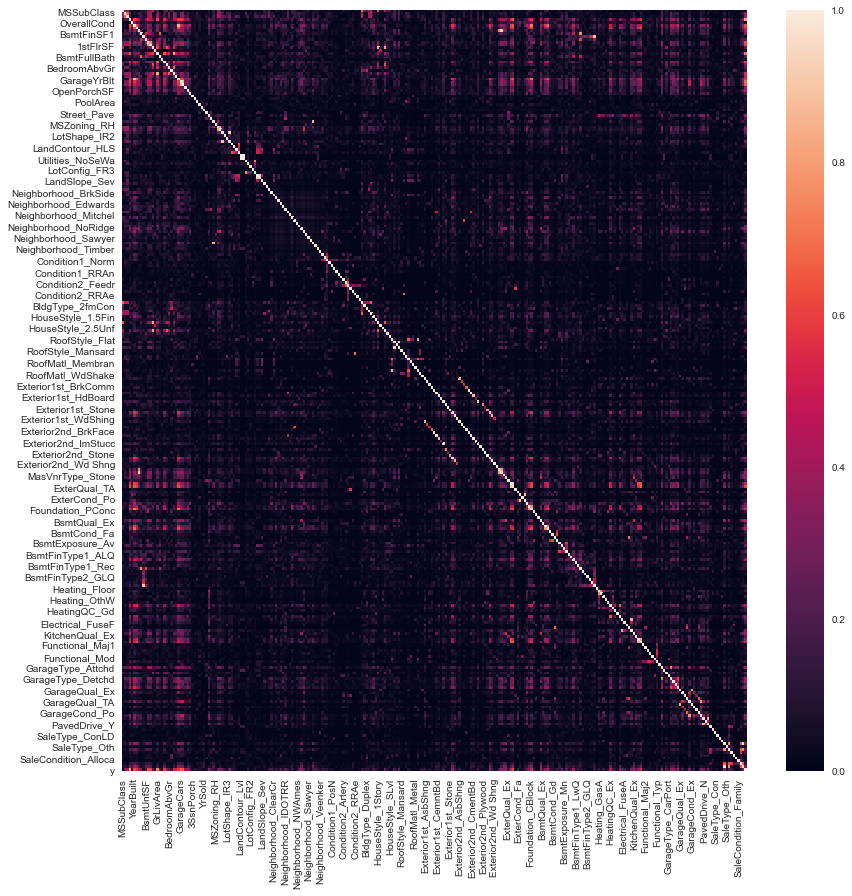

In [17]:
Corr = T.corr().abs()#.sort_values('y', ascending=False)
plt.figure(figsize=(14, 14))
sns.heatmap(Corr)
plt.show()

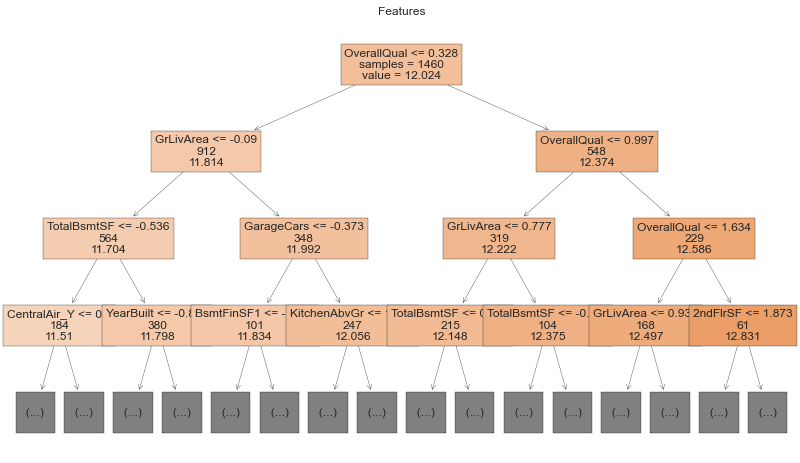

In [18]:
if learning == 'Regression':
    dt = DecisionTreeRegressor()
else:
    dt = DecisionTreeClassifier()
dt.fit(train_X, y)
plt.figure(figsize = (14, 8))
plot_tree(dt, 
          max_depth = 3, 
          filled = True, 
          fontsize=12, 
          label='root', 
          impurity=False, 
          feature_names=train_X.columns
         )
plt.title('Features')
plt.show()

In [19]:
if learning == 'Regression':
    model = LGBMRegressor()
else:
    model = LGBMClassifier()
    
Fstack = RFECV(model, scoring = evaluation)

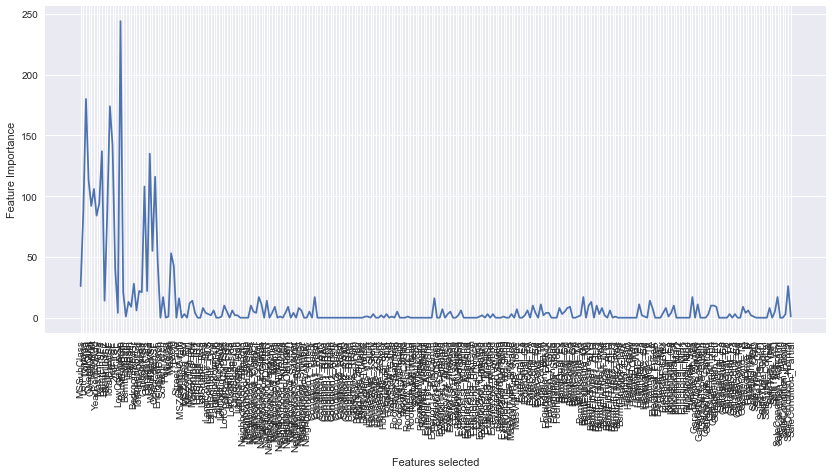

In [37]:
model.fit(train_X, y)

plt.figure(figsize=(14, 6))
plt.xlabel("Features selected")
plt.ylabel("Feature Importance")
plt.plot(train_X.columns.to_list(), model.feature_importances_)
plt.xticks(np.arange(train_X.shape[1]), train_X.columns.tolist(), rotation=90);

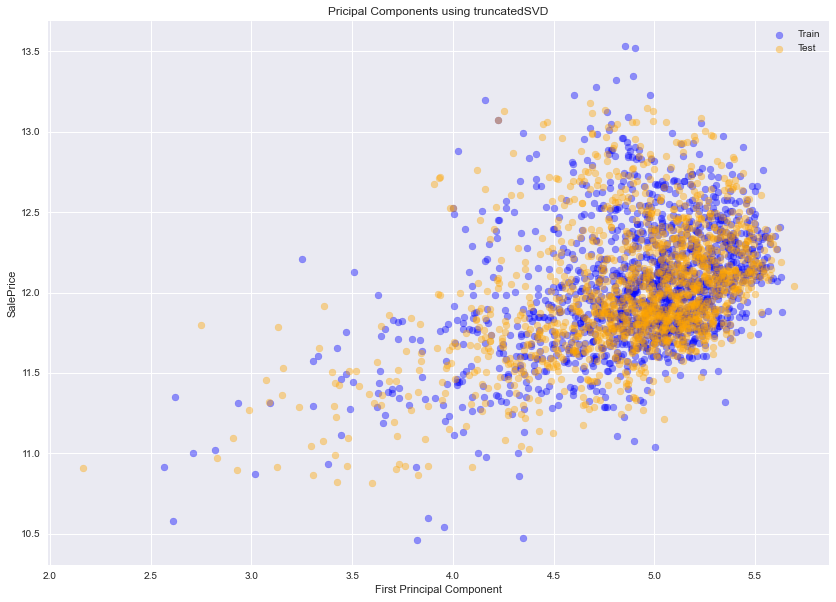

In [21]:
svd = sklearn.decomposition.TruncatedSVD()
svd.fit(train_X)

plt.figure(figsize = (14, 10))
plt.scatter(svd.transform(train_X)[:, 0], 
            y, 
            c = 'blue',
            alpha = 0.4, 
            label = 'Train'
           )

plt.scatter(svd.transform(test_X)[:, 0], 
            model.predict(test_X), 
            c = 'orange', 
            alpha = 0.4, 
            label = 'Test'
           )

plt.title('Pricipal Components using truncatedSVD')
plt.xlabel('First Principal Component')
plt.ylabel(target)
plt.legend()
plt.show()

In [22]:
# Fstack.fit(train_X, y)

In [23]:
# rfescore = Fstack.grid_scores_
# plt.figure(figsize=(14, 6))
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# plt.plot(range(1, len(rfescore) + 1), rfescore)
# plt.axvline(Fstack.n_features_, color='blue')
# # plt.xticks(list(plt.xticks()[0]) + [Fstack.n_features_])
# plt.show()

In [24]:
# print (Fstack.n_features_)
# print (Fstack.grid_scores_.max())
# cc = Fstack.get_support()

In [25]:
cimp = train_X.columns.tolist()
# cimp = train_X.columns[cc].tolist()
print (cimp)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'Street_Pave', 'CentralAir_Y', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'Utilities_AllPub', 'Utilities_NoSeWa', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_

In [26]:
train_csv = train_X[cimp]
test_csv = test_X[cimp]

train_csv[target] = y
test_csv[Id] = raw_test_data[Id].tolist()
train_csv[Id] = raw_train_data[Id].tolist()

In [27]:
from sklearn.neighbors import KNeighborsClassifier
aval_model = KNeighborsClassifier(n_neighbors=7)

it = np.array([0]*size_train + [1]*raw_test_data.shape[0])
aval_model.fit(ZD, it)
ip = aval_model.predict(ZD)
sklearn.metrics.accuracy_score(it, ip)

0.6536485097636177

In [28]:
ival = ip[:size_train]==1
sum(ival)

511

In [29]:
probs = aval_model.predict_proba(ZD[:size_train])[:, 1]

In [30]:
val_csv = train_csv[ival]
# train_csv = train_csv[~ival]

In [31]:
train_csv.to_csv('data\\train.csv', index=False)
test_csv.to_csv('data\\test.csv', index=False)
val_csv.to_csv('data\\val.csv', index=False)

In [34]:
test_csv.head()#.transpose()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Id
1460,-1.117452,0.553114,0.574141,-0.761451,0.480006,-0.504882,-1.127088,-0.768637,0.322493,2.734501,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1461
1461,-1.117452,0.595321,1.010175,-0.017057,0.480006,-0.592367,-1.220341,0.780093,1.134176,-0.365991,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1462
1462,0.432789,0.292220,0.945559,-0.761451,-0.453217,0.863747,0.580632,-0.768637,0.935473,-0.365991,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1463
1463,0.432789,0.467666,0.231909,-0.017057,0.480006,0.910126,0.580632,-0.361421,0.604881,-0.365991,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1464
1464,1.415788,-1.313362,-1.288756,1.322129,-0.453217,0.637955,0.200395,-0.768637,-0.228298,-0.365991,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1465


### to do

1. drop the columns that have only one value in train_X
2. drop the columns that are identical with another column (check this after standardising) 
        see pd.duplicated
3. check the effects of svd and how to use it
4. add isNull features to all the imputed float columns
5. Check out pandas-profiling. Its supposed to be AWESOME
6. Mean Encoding. This may be incredible.
        cumsum = train_X.groupby(col)['y'].cumsum() - train['y']
        cumcnt = train.groupby(col).cumcount()
        train_new[col+'_mean_y'] = cumsum/cumcnt
        
7. write the new files in hdf5 or npy format
8. downcast the data into 32-bits from 64-bits when memory size becomes imp
9. FEATURE ENGINEERING AND EXPLOITING LEAKS IS MORE IMPORTANT THAN OPTIMIZATIONS
10. What is bray-curtis method
11. Check all types of dimensionality reduction
        PCA, SVD, Truncated_SVD, NMF
        
12. Check tree_model.apply() function. 
13. Adaboost may work with input models. As well as GBM of sklearn. 
14. Check Xgboost, LightGBM, H2O GBM, Catboost

15. Factorization machine(libfm) check this out as well
16. Check out the Stacknet